## Necessary Imports

In [69]:
from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

Set up directories based on where the program is being run from

In [70]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    op_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(op_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


List case to choose one of interest

In [71]:
all_cases = os.listdir('mnth15runs/')
all_cases

['20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 'error_vs_iso.png',
 '.ipynb_checkpoints',
 'unused',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 'runs_as_vectors.png',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 'paramspace.png',
 '20191122_161009_sampleparamset_wbf_1_inp_1']

Pick run to analyze

In [72]:
specific_model = '20191230_130025_singleparam_cttest15_wbf_1_inp_1.nc'
case = specific_model[:-3]

run_dir = 'mnth15runs/%s/' % case # inconsistent label compared to jupy_test
#run_dir = 'NorESM_validation/%s' % ct_val
print(run_dir, os.path.exists(run_dir))

mnth15runs/20191230_130025_singleparam_cttest15_wbf_1_inp_1/ True


Ongoing list of variables of interest

In [73]:
relevant_vars = [
     'CLDFREE', 'CLDHGH','CLDICE', 'CLDLIQ', 'CLDLOW','CLDMED',
     'CLDTAU','CLDTOT','CLD_ISOTM','CLD_ISOTM_NONSIM','CLD_SLF',
     'CLD_SLF_NONSIM','CLOUD','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
     'CONCLD', 'BERGO','BERGOXCLD_ISOTM','BERGOXCLD_ISOTM_NONSIM',
     'BERGSO','BERGSOXCLD_ISOTM','BERGSOXCLD_ISOTM_NONSIM',
     'MG_SADICE','MG_SADLIQ','MNUCCCO','MNUCCDO','MNUCCDOhet',
     'MNUCCRO','MNUCCTO','NUMICE','NUMLIQ','NUMRAI','NUMSNO',
     'N_AER','PRECIPBINOCC_CC','PRECIPBINOCC_CL','PRECIPBINOCC_CT',
     'PRECIPBINRATE_CC','PRECIPBINRATE_CL','PRECIPBINRATE_CT', 
     'SADICEXCLD_ISOTM','SADICEXCLD_ISOTM_NONSIM','SADLIQXCLD_ISOTM',
     'SADLIQXCLD_ISOTM_NONSIM','SLFXCLD_ISOTM','SLFXCLD_ISOTM_NONSIM',
     'cell_weight','SLF_ISOTM','SLF_ISOTM_AVG', 'TS', 'CT_CLD_ISOTM',
     'CT_SLF', 'CT_SLFXCLD_ISOTM'
    ]

This currently doesn't really work. WATT

Load cloudtop SLFs and construct global and regional averages and stds
This should be more flexible for arbitrary latitude ranges.

In [88]:
# Load NorESM data
ds = xr.open_dataset('%s/%s.nc' % (run_dir,case))
if (len(ds['time']) > 1):
    ds = ds.sel(time=slice('0001-04-01', '0002-03-01'))
ds = add_weights(ds)

ds['CT_SLF'] = ds['CT_SLFXCLD_ISOTM']/ds['CT_CLD_ISOTM']
ct_slf_noresm = ds['CT_SLF']

ds['CT_SLF_ISOTM_AVG'] = ds['CT_SLF'].mean(dim = 'time', skipna=True)

# Load CALIOP data
ct_slf_caliop = xr.open_dataset('caliop_cloudtop/cloudtop_slfs.nc')

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Define latitude ranges of interest.

In [75]:
bands = {'Global':[-90,90],'Arctic':[66.667,90],'Antarctic':[-90,-66.667]}
df = pd.DataFrame()

In [94]:
#df['isotherm'] = slf1['isotherm']
#df = df.set_index('isotherm')
for i in bands:
    _rng = bands[i]
    
    # Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
    mask1 = np.bitwise_or(ct_slf_caliop['lat']<_rng[0], ct_slf_caliop['lat']>_rng[1])
    mask2 = np.bitwise_or(ct_slf_noresm['lat']<_rng[0], ct_slf_noresm['lat']>_rng[1])
    
    weight1 = ct_slf_caliop['cell_weight']
    weight2 = ds['cell_weight'] #*ds['CT_CLD_ISOTM'] #Not sure about this
    
    slf1 = 100*masked_average(ct_slf_caliop['SLF'], dim=['lat','lon'],weights=weight1, mask=mask1)
    slf2 = 100*masked_average(ct_slf_noresm, dim=['lat','lon','time'],weights=weight2, mask=mask2)
    
    stdev1 = 100*np.std(ct_slf_caliop['SLF'].sel(lat=slice(_rng[0],_rng[1])), axis=(0,1))
    stdev2 = 100*np.std(ct_slf_noresm.sel(lat=slice(_rng[0],_rng[1])), axis=(0,2,3))
    
    df['CALIOP %s SLF' % i] = slf1
    df['CALIOP %s StDev' % i] = stdev1
    df['NorESM %s SLF' % i] = slf2
    df['NorESM %s StDev' % i] = stdev2
df['isotherm'] = slf1['isotherm']
df

,CALIOP Global SLF,CALIOP Global StDev,NorESM Global SLF,NorESM Global StDev,CALIOP Arctic SLF,CALIOP Arctic StDev,NorESM Arctic SLF,NorESM Arctic StDev,CALIOP Antarctic SLF,CALIOP Antarctic StDev,NorESM Antarctic SLF,NorESM Antarctic StDev,isotherm
0,2.652094,5.807777,3.822959,17.586182,2.448328,2.686922,5.092532,16.641714,4.095303,4.009299,13.961278,30.321438,-40.0
1,16.110721,16.863898,23.234846,39.220856,11.182338,6.798517,34.588168,42.014248,29.083648,11.664116,60.165698,43.463421,-35.0
2,48.726922,26.783687,31.205616,42.484108,39.743815,11.886540,55.344561,45.543270,76.344829,9.706979,79.000091,34.763443,-30.0
3,68.557867,23.702292,44.925724,42.871029,66.755759,9.768171,74.332099,39.249313,84.836145,16.758521,88.480420,27.545029,-25.0
4,82.848191,18.481084,55.243124,40.328773,86.842881,6.023320,90.291369,21.637074,90.111826,17.041121,96.064839,12.643554,-20.0
5,89.782925,14.106420,68.141872,35.095181,94.521922,3.525254,96.001248,11.172071,94.810568,13.430821,98.942822,4.343795,-15.0
6,90.960496,13.894029,71.601288,33.459175,96.992953,3.093767,97.969091,7.101339,95.970086,13.618475,99.912542,1.338465,-10.0
7,91.791636,14.734814,88.768926,22.762476,97.131304,5.642598,99.823913,0.967777,96.772004,11.817037,99.938047,1.590085,-5.0
8,96.874805,9.863054,96.061309,13.541820,98.369610,5.955775,99.985028,0.128470,96.684488,15.223417,99.995633,0.008665,0.0


In [95]:
data_string = '%scloudtop_slf_comparison.csv' % run_dir
df.to_csv(path_or_buf = data_string)

PermissionError: [Errno 13] Permission denied: 'mnth15runs/20191230_130025_singleparam_cttest15_wbf_1_inp_1/cloudtop_slf_comparison.csv'

Text(0.5,0.98,'20191230_130025_singleparam_cttest15_wbf_1_inp_1')

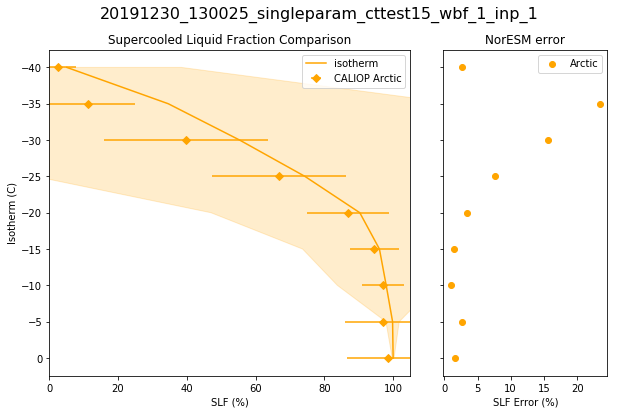

In [96]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig1)#, hspace=0.4)
f1_ax1 = fig1.add_subplot(spec1[0, :-1])
f1_ax2 = fig1.add_subplot(spec1[0, -1], sharey=f1_ax1)
axes = [f1_ax1, f1_ax2]
plt.setp(f1_ax2.get_yticklabels(), visible=False)

#isos = np.array(all_slf_clean.index).reshape(-1,1)

fig1.gca().invert_yaxis()
f1_ax1.set_title('Supercooled Liquid Fraction Comparison'); f1_ax1.set_ylabel('Isotherm (C)'); f1_ax1.set_xlabel('SLF (%)')
f1_ax2.set_title('NorESM error'); f1_ax2.set_xlabel('SLF Error (%)')

colors = ['blue', 'orange', 'red']

for b,c in zip(bands, colors):
    if b == 'Arctic':
        f1_ax1.errorbar(df['CALIOP %s SLF' % b], df['isotherm'], xerr=2*df['CALIOP %s StDev' % b], label='CALIOP %s' % b, color = c, fmt='o', marker='D')
        f1_ax1.plot(df['NorESM %s SLF' % b], df['isotherm'], color = c) #, label=b)
        f1_ax1.fill_betweenx(df['isotherm'], df['NorESM %s SLF' % b] - 2*df['NorESM %s StDev' % b], df['NorESM %s SLF' % b] + 2*df['NorESM %s StDev' % b], alpha=0.2, color=c)

        slf_error = df['NorESM %s SLF' % b] - df['CALIOP %s SLF' % b]
        f1_ax2.scatter(slf_error, df['isotherm'], color=c, label=b)

#_r = regress_1d(isos, all_slf_clean[error])
#_s = _r.score(isos, all_slf_clean[error])
#f1_ax2.plot(_r.predict(isos), isos, color=color, label = ('$R^2 = %f$' % _s))

f1_ax1.set_xlim((0,105))
f1_ax1.legend()
f1_ax2.legend()

fig1.suptitle(case, fontsize=16)

In [97]:
filename = '%s_slf_comparison.png' % case
filename
if not os.path.exists(filename):
    fig1.savefig(run_dir + filename,format = 'png', dpi = 200)
    fig1.clf()

PermissionError: [Errno 13] Permission denied: 'mnth15runs/20191230_130025_singleparam_cttest15_wbf_1_inp_1/20191230_130025_singleparam_cttest15_wbf_1_inp_1_slf_comparison.png'

Plot the global SLF at each isotherm

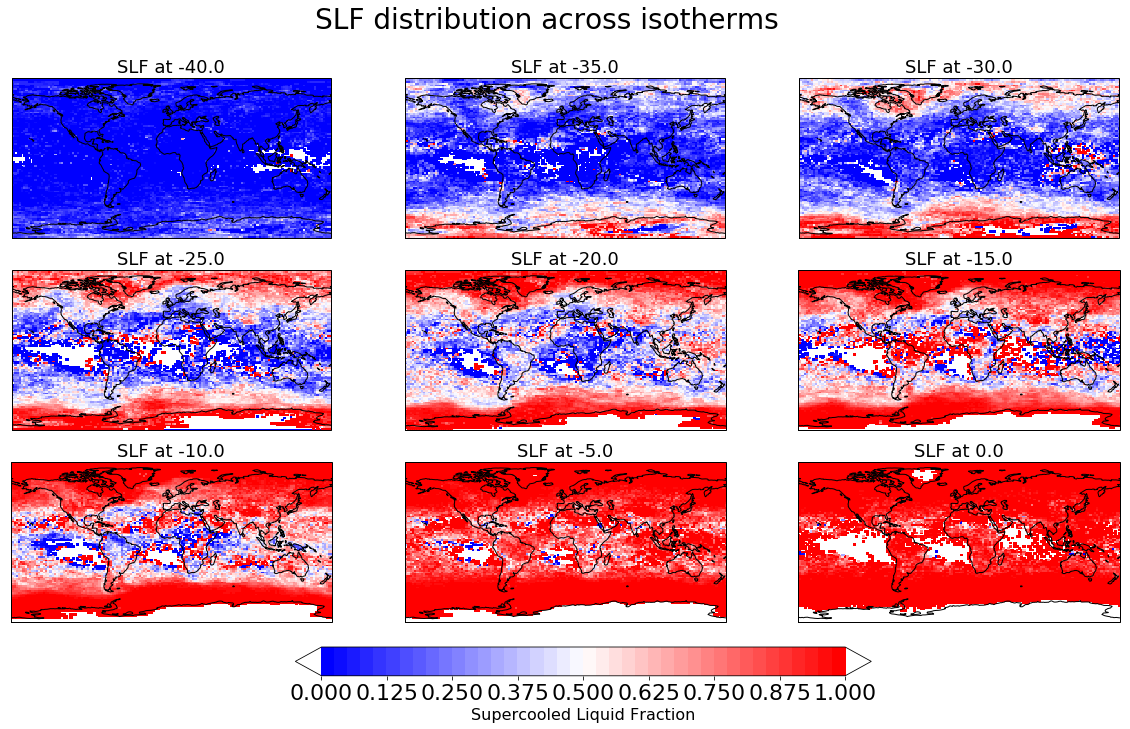

In [89]:
iso_fig = plot_slf_isotherms(ds)

In [90]:
filename = '%s_noresm_slf_isotherms.png' % case
filename
if not os.path.exists(filename):
    iso_fig.savefig(run_dir + filename,format = 'png', dpi = 200)
    iso_fig.clf()

PermissionError: [Errno 13] Permission denied: 'mnth15runs/20191230_130025_singleparam_cttest15_wbf_1_inp_1/20191230_130025_singleparam_cttest15_wbf_1_inp_1_noresm_slf_isotherms.png'

# TRash!

In [111]:
hybrid_weight = ds['cell_weight']#*ds['CT_CLD_ISOTM'] # I am trying to weight by both the cloud amount and gridbox area

mask = ct_slf_noresm['lat']>70

weighted_ct_slf = 100*masked_average(ct_slf_noresm, dim=['lat','lon','time'],weights=hybrid_weight, mask=mask)
weighted_ct_slf = 100*masked_average(ct_slf_noresm, dim=['lat','lon','time'], mask=mask)

ct_slf_noresm_arc = weighted_ct_slf

In [10]:
ct_slf_caliop = xr.open_dataset('caliop_cloudtop/cloudtop_slfs.nc')['SLF']

arctic_avg = 100*ct_slf_caliop.sel(lat=slice(70,90)).mean(dim=['lat','lon'])
arctic_stdev = 100*np.std(ct_slf_caliop.sel(lat=slice(70,90)), axis=(0,1)) 
global_avg = 100*ct_slf_caliop.mean(dim=['lat','lon'])
global_stdev = 100*np.std(ct_slf_caliop, axis=(0,1)) 

Calculate the 'equivalent' cloudtop variable from the model outpt

In [110]:
ds = xr.open_dataset('%s/%s.nc' % (run_dir,case))
if (len(ds['time']) > 1):
    ds = ds.sel(time=slice('0001-04-01', '0002-03-01'))
ds = add_weights(ds)

ct_slf_noresm = ds['CT_SLFXCLD_ISOTM']/ds['CT_CLD_ISOTM']
# should weight by both area and cloud fraction here
ct_slf_noresm_arc = 100*ct_slf_noresm.sel(lat=slice(70,90)).mean(dim=['lat','lon'])

Calculate the same averages from the model output.